# CSV dataset

In [ ]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline

# Don't Show Warning Messages
import warnings
warnings.filterwarnings('ignore')

from pydub import AudioSegment
import IPython

import soundfile as sf

In [ ]:
file_list = os.listdir('../dataset/Respiratory_Sound_Database/audio_and_txt_files')[1:]
col_files = ['patient_id','recording_index','Chest_location','Acquisition_mode','Recording_equipment','file_name']
df_files = pd.DataFrame(columns = col_files)


col_names = ['Beginning_of_respiratory_cycle', 'End_of_respiratory_cycle', 'Presence/absence_of_crackles', 'Presence/absence_of_wheezes']

for i,file_name in enumerate(file_list[0::2]):
    text_file = file_name[0:-4]+'.txt'
    df_annot = pd.read_csv('../dataset/Respiratory_Sound_Database/audio_and_txt_files/'+text_file, sep="\t", header=None, names=col_names)
    df_files.loc[i,'crackles'] = df_annot[col_names[2]].sum()
    df_files.loc[i, 'wheezes'] = df_annot[col_names[3]].sum()
    df_files.loc[i, 'all_crackles_wheeze'] = df_annot[(df_annot[col_names[2]]==1)&(df_annot[col_names[3]]==1)].count()[0]

df_patient = pd.read_csv('patient_info.csv')

df_all= pd.merge(df_patient, df_files, on=  "patient_id")
df_all.to_csv('data_all.csv',index = False)

# make dataset

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import numpy
import matplotlib.pyplot as plt
import matplotlib
import librosa
import librosa.display
from librosa import amplitude_to_db 
from pydub import AudioSegment
%matplotlib inline

from pydub import AudioSegment
import IPython

import soundfile as sf
import warnings
warnings.filterwarnings('ignore')


C:\Users\user\.conda\envs\sound\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


# to numpy

In [2]:
frame_length = 0.025 #s
frame_stride = 0.010 #s

def audio_preprocessing(save_file, path = 'new_slice.wav'):
    y, sr = librosa.load(path)
    input_nfft = int(round(sr*frame_length)) 
    input_stride = int(round(sr*frame_stride))
    
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    np.save('../data/MFCC/'+save_file+'.npy', mfcc)
    
    stft = librosa.stft(y, n_fft=input_nfft, hop_length=input_stride)
    stft = librosa.amplitude_to_db(abs(stft))
    np.save('../data/STFT/'+save_file+'.npy', stft)
    
    mel = librosa.feature.melspectrogram(y=y, n_mels=40, n_fft=input_nfft, hop_length=input_stride) 
    mel = librosa.power_to_db(np.abs(mel), ref=np.max)
    np.save('../data/MEL/'+save_file+'.npy', mel)

def cutAudio(path, st, end):
    st = st*1000
    end = end*1000
    audio = AudioSegment.from_wav(path)
    audio = audio[st:end]
    return audio

In [3]:
df_data = pd.read_csv('../dataset/data_all.csv')
data_csv = pd.DataFrame(columns=['patient_id', 'diagnosis', 'mfcc', 'stft', 'mel'])

csv_index = 0
for i in range(len(df_data)):
    path = '../dataset/Respiratory_Sound_Database/audio_and_txt_files/'+str(df_data['file_name'][i])+'.wav'
    
    data, sr = sf.read(path)
    T_length = int(len(data)/sr)
    st = 0
    end = 7
    count = 0
    
    while end<=T_length:
        save_name = str(df_data['patient_id'][i])+'_'+str(df_data['diagnosis'][i])+'_'+str(i)+'_'+str(int(count))
        wav_file = cutAudio(path, st, end)
        wav_file.export('new_slice.wav', format="wav")
        
        audio_preprocessing(save_name)
        
        data_csv.loc[csv_index] = [df_data['patient_id'][i],str(df_data['diagnosis'][i]), 
                                   '../data/MFCC/'+save_name+'.npy',
                                   '../data/STFT/'+save_name+'.npy', 
                                   '../data/MEL/'+save_name+'.npy']
        
        st+=5
        end+=5
        count+=1
        csv_index+=1

data_csv.to_csv('../data/dataset.csv',index =False)

In [4]:
 y, sr = librosa.load(path)
input_nfft = int(round(sr*frame_length)) 
input_stride = int(round(sr*frame_stride))
    
mfcc = librosa.feature.mfcc(y=y, sr=sr)
    
stft = librosa.stft(y, n_fft=input_nfft, hop_length=input_stride)
stft = librosa.amplitude_to_db(abs(stft))
    
mel = librosa.feature.melspectrogram(y=y, n_mels=40, n_fft=input_nfft, hop_length=input_stride) 
mel = librosa.power_to_db(np.abs(mel), ref=np.max)
    
print('mfcc size: ', mfcc.shape)
print('stft size: ', stft.shape)
print('mel size: ', mel.shape)

mfcc size:  (20, 862)
stft size:  (276, 2005)
mel size:  (40, 2005)


In [5]:
data_csv['URTI'] = 0
data_csv['Healthy'] = 0
data_csv['COPD'] = 0
data_csv['Asthma'] = 0
data_csv['LRTI'] = 0
data_csv['Bronchiectasis'] = 0
data_csv['Pneumonia'] = 0
data_csv['Bronchiolitis'] = 0

for i in range(len(data_csv)):
    data_csv.loc[i,data_csv.loc[i,'diagnosis']] = 1
data_csv.to_csv('../data/dataset.csv', index= False)

diagnosis = ['URTI','Healthy','COPD','Asthma','LRTI','Bronchiectasis','Pneumonia','Pneumonia','Bronchiolitis']
for diag in diagnosis:
    DF = data_csv[data_csv[diag]==1]
    DF.to_csv('../data/'+diag+'.csv', index = False)

In [6]:
def d_subdata(x, df):
    ret = {}
    df_sub = pd.DataFrame(df[x])
    df_sub.drop_duplicates(inplace = True)
    df_sub.sort_values([x], ascending=[True],inplace = True)
    df_sub.reset_index(drop=True)
    for y in df_sub[x]:
        print(y, ' : ', len(df[df[x]==y]))
        ret[y] = len(df[df[x]==y])
    return ret

Asthma  :  3
Bronchiectasis  :  48
Bronchiolitis  :  39
COPD  :  2667
Healthy  :  105
LRTI  :  6
Pneumonia  :  111
URTI  :  69


<BarContainer object of 8 artists>

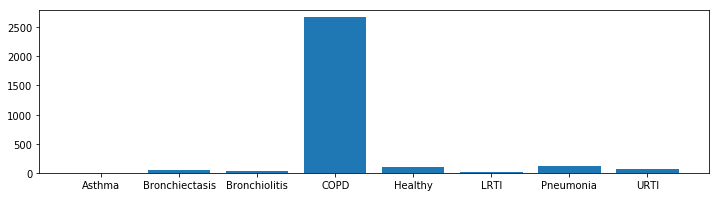

In [7]:
myDictionary = d_subdata('diagnosis', data_csv)
plt.figure(figsize=(12, 3))
plt.bar(myDictionary.keys(), myDictionary.values())

Asthma  :  2
Bronchiectasis  :  32
Bronchiolitis  :  26
COPD  :  1815
Healthy  :  70
LRTI  :  4
Pneumonia  :  74
URTI  :  46


<BarContainer object of 8 artists>

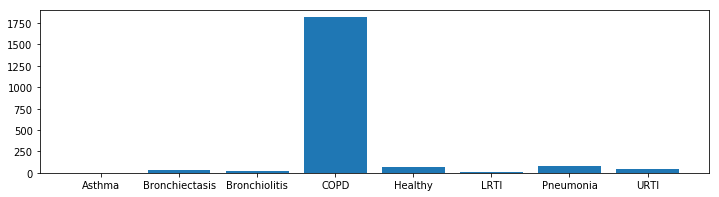

In [10]:
myDictionary = d_subdata('diagnosis', data_csv)
plt.figure(figsize=(12, 3))
plt.bar(myDictionary.keys(), myDictionary.values())

# to image

In [2]:
def cutAudio(path, st, end):
    st = st*1000
    end = end*1000
    audio = AudioSegment.from_wav(path)
    audio = audio[st:end]
    return audio

def figure_stft(data, sr, save = None):
    D = librosa.amplitude_to_db(data, ref=np.max)
    #fig.set_dpi(35)
    #fig.set_size_inches(8, 6)
    librosa.display.specshow(D, y_axis='log', x_axis='time',sr = sr)
    plt.tight_layout()
    if save!=None: 
        plt.savefig('../dataset/STFTs/'+save+'.png',bbox_inches='tight')
    else: 
        plt.colorbar(format='%+0.1f dB')
        plt.show()
    plt.clf()
        
def stft(data, n_fft = 2048):
    # n_fft : window size
    return librosa.stft(data, n_fft = n_fft, hop_length = int(n_fft*0.25))

def get_wav_info(wav_file):
    data, sr = sf.read(wav_file)
    return data, sr

In [ ]:
df_data = pd.read_csv('../dataset/data_all.csv')
stft_csv = pd.DataFrame(columns=['file_name','patient_id', 'diagnosis'])
stft_index = 0

for i in range(len(df_data)):
    path = '../dataset/Respiratory_Sound_Database/audio_and_txt_files/'+str(df_data['file_name'][i])+'.wav'
    
    data, sr = get_wav_info(path)
    T_length = int(len(data)/sr)
    st = 0
    end = 4
    count = 0
    while end<=T_length:
        save_name = str(df_data['patient_id'][i])+'_'+str(df_data['diagnosis'][i])+'_'+str(i)+'_'+str(int(count))
        wav_file = cutAudio(path, st, end)
        wav_file.export('new_slice.wav', format="wav")
        data, sr = get_wav_info('new_slice.wav')
        Time = np.linspace(0,4, num=len(data))
        fig = matplotlib.pyplot.gcf()
        fig.set_dpi(35)
        fig.set_size_inches(8, 6)
        plt.plot(Time,data)
        plt.savefig('../dataset/SIGNALs/'+save_name+'.png',bbox_inches='tight')
        plt.clf()
        s_data = stft(data)
        figure_stft(np.abs(s_data),sr, save =save_name )
        plt.clf()
        stft_csv.loc[stft_index] = ['../dataset/STFTs/'+save_name+'.png', df_data['patient_id'][i],str(df_data['diagnosis'][i])]
        st+=3
        end+=3
        count+=1
        stft_index+=1

stft_csv.to_csv('../dataset/file_csv.csv',index =False)

In [3]:
# just sound file 7s overlap 0s
df_data = pd.read_csv('../dataset/data_all.csv')
wav_csv = pd.DataFrame(columns=['file_name','patient_id', 'diagnosis'])
index = 0

for i in range(len(df_data)):
    path = '../dataset/Respiratory_Sound_Database/audio_and_txt_files/'+str(df_data['file_name'][i])+'.wav'
    
    data, sr = get_wav_info(path)
    T_length = int(len(data)/sr)
    st = 0
    end = 7
    count = 0
    while end<=T_length:
        save_name = str(df_data['patient_id'][i])+'_'+str(df_data['diagnosis'][i])+'_'+str(i)+'_'+str(int(count))
        wav_file = cutAudio(path, st, end)
        wav_file.export('../dataset/WAVs/'+save_name+'.wav', format="wav")
        wav_csv.loc[index] = ['../dataset/WAVs/'+save_name+'.wav', df_data['patient_id'][i],str(df_data['diagnosis'][i])]
        st+=7
        end+=7
        count+=1
        index+=1

wav_csv.to_csv('../dataset/wav_7s.csv',index =False)

# Target value set

In [1]:
import pandas as pd
stft_csv = pd.read_csv('../dataset/file_csv.csv')
stft_csv['URTI'] = 0
stft_csv['Healthy'] = 0
stft_csv['COPD'] = 0
stft_csv['Asthma'] = 0
stft_csv['LRTI'] = 0
stft_csv['Bronchiectasis'] = 0
stft_csv['Pneumonia'] = 0
stft_csv['Bronchiolitis'] = 0

for i in range(len(stft_csv)):
    stft_csv.loc[i,stft_csv.loc[i,'diagnosis']] = 1
    
stft_csv.to_csv('../dataset/dataset_csv.csv', index= False)

In [2]:
stft_csv.head()

,file_name,patient_id,diagnosis,URTI,Healthy,COPD,Asthma,LRTI,Bronchiectasis,Pneumonia,Bronchiolitis
0,../dataset/STFTs/101_URTI_0_0.png,101,URTI,1,0,0,0,0,0,0,0
1,../dataset/STFTs/101_URTI_0_1.png,101,URTI,1,0,0,0,0,0,0,0
2,../dataset/STFTs/101_URTI_0_2.png,101,URTI,1,0,0,0,0,0,0,0
3,../dataset/STFTs/101_URTI_0_3.png,101,URTI,1,0,0,0,0,0,0,0
4,../dataset/STFTs/101_URTI_0_4.png,101,URTI,1,0,0,0,0,0,0,0


# DATA image crop

In [1]:
import pandas as pd
from PIL import Image
stft_csv = pd.read_csv('../dataset/file_csv.csv')

for i in range(len(stft_csv)):
    path = stft_csv.loc[i,'file_name']
    img = Image.open(path)
    img = img.crop((30,10,270,187))
    img.save(path[0:11]+'DATAset'+path[16:])

In [ ]:
import cv2
import pandas as pd
import pandas as pd
from PIL import Image
stft_csv = pd.read_csv('../dataset/dataset_csv.csv')

for i in range(len(stft_csv)):
    path = stft_csv.loc[i,'crop_path']
    img = Image.open(path)
    r,g,b,a = cv2.split(img)
    new_img = cv2.merge([r, g, b])
    new_img.save(path[0:11]+'DATA_3ch'+path[16:])


# crop DATA restore

In [1]:
import pandas as pd
stft_csv = pd.read_csv('../dataset/dataset_csv.csv')

for i in range(len(stft_csv)):
    path = stft_csv.loc[i,'file_name']
    new_path = path[0:11]+'DATAset'+path[16:]
    stft_csv.loc[i,'crop_path'] = new_path
stft_csv.to_csv('../dataset/dataset_csv.csv', index = False)

In [2]:
stft_csv.head()

,Unnamed: 0,file_name,patient_id,diagnosis,URTI,Healthy,COPD,Asthma,LRTI,Bronchiectasis,Pneumonia,Bronchiolitis,crop_path
0,0,../dataset/STFTs/101_URTI_0_0.png,101,URTI,1,0,0,0,0,0,0,0,../dataset/DATAset/101_URTI_0_0.png
1,1,../dataset/STFTs/101_URTI_0_1.png,101,URTI,1,0,0,0,0,0,0,0,../dataset/DATAset/101_URTI_0_1.png
2,2,../dataset/STFTs/101_URTI_0_2.png,101,URTI,1,0,0,0,0,0,0,0,../dataset/DATAset/101_URTI_0_2.png
3,3,../dataset/STFTs/101_URTI_0_3.png,101,URTI,1,0,0,0,0,0,0,0,../dataset/DATAset/101_URTI_0_3.png
4,4,../dataset/STFTs/101_URTI_0_4.png,101,URTI,1,0,0,0,0,0,0,0,../dataset/DATAset/101_URTI_0_4.png


# CSV for diagnosis

In [1]:
import pandas as pd
df_csv = pd.read_csv('../dataset/dataset_csv.csv')
diagnosis = ['URTI','Healthy','COPD','Asthma','LRTI','Bronchiectasis','Pneumonia','Pneumonia','Bronchiolitis']
for diag in diagnosis:
    DF = df_csv[df_csv[diag]==1]
    DF.to_csv('../dataset/'+diag+'.csv', index = False)

In [ ]:
csv_path = ['../dataset/'+diagnosis[0]+'.csv',
            '../dataset/'+diagnosis[1]+'.csv',
            '../dataset/'+diagnosis[2]+'.csv',
            '../dataset/'+diagnosis[3]+'.csv',
            '../dataset/'+diagnosis[4]+'.csv',
            '../dataset/'+diagnosis[5]+'.csv',
            '../dataset/'+diagnosis[6]+'.csv',
            '../dataset/'+diagnosis[7]+'.csv',
            '../dataset/'+diagnosis[8]+'.csv',]

# DATA plot

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def d_subdata(x, df):
    ret = {}
    df_sub = pd.DataFrame(df[x])
    df_sub.drop_duplicates(inplace = True)
    df_sub.sort_values([x], ascending=[True],inplace = True)
    df_sub.reset_index(drop=True)
    for y in df_sub[x]:
        print(y, ' : ', len(df[df[x]==y]))
        ret[y] = len(df[df[x]==y])
    return ret

Asthma  :  1
Bronchiectasis  :  16
Bronchiolitis  :  13
COPD  :  793
Healthy  :  35
LRTI  :  2
Pneumonia  :  37
URTI  :  23


<BarContainer object of 8 artists>

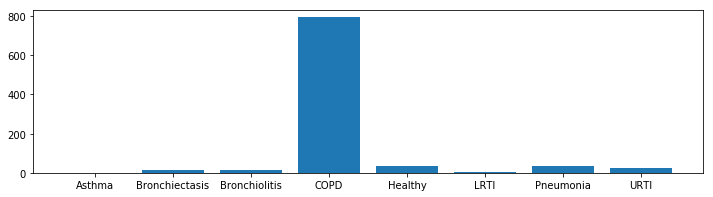

In [3]:
df_data = pd.read_csv('../dataset/data_all.csv')
myDictionary = d_subdata('diagnosis', df_data)
plt.figure(figsize=(12, 3))
plt.bar(myDictionary.keys(), myDictionary.values())

Asthma  :  6
Bronchiectasis  :  96
Bronchiolitis  :  78
COPD  :  5194
Healthy  :  210
LRTI  :  12
Pneumonia  :  222
URTI  :  138


<BarContainer object of 8 artists>

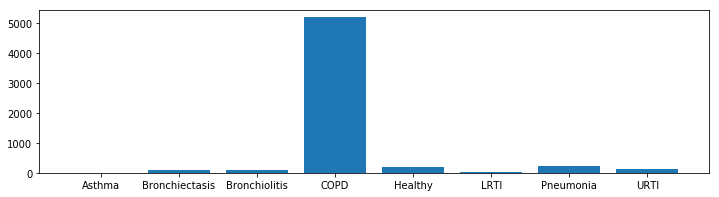

In [4]:
df_data = pd.read_csv('../dataset/file_csv.csv')
myDictionary = d_subdata('diagnosis', df_data)
plt.figure(figsize=(12, 3))
plt.bar(myDictionary.keys(), myDictionary.values())

Asthma  :  2
Bronchiectasis  :  32
Bronchiolitis  :  26
COPD  :  1815
Healthy  :  70
LRTI  :  4
Pneumonia  :  74
URTI  :  46


<BarContainer object of 8 artists>

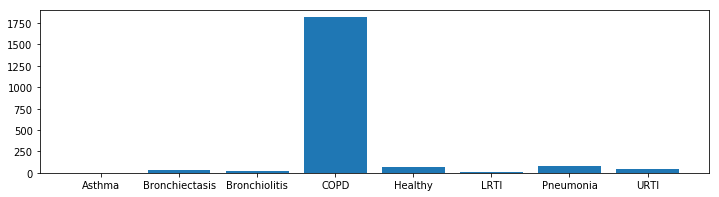

In [3]:
df_data = pd.read_csv('../dataset/wav_7s.csv')
myDictionary = d_subdata('diagnosis', df_data)
plt.figure(figsize=(12, 3))
plt.bar(myDictionary.keys(), myDictionary.values())

In [ ]:
df_data = pd.read_csv('../dataset/stft_7_3.csv')
myDictionary = d_subdata('diagnosis', df_data)
plt.figure(figsize=(12, 3))
plt.bar(myDictionary.keys(), myDictionary.values())